In [1]:
!pip install -q datasets transformers torch==2.5.1 fsspec==2024.10.0 peft bitsandbytes trl accelerate sentencepiece tiktoken requests huggingface_hub jsonlines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# import dependecies
import os
import torch
import transformers
import pandas as pd
import datasets
from google.colab import drive
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
from peft import LoraConfig
from trl import SFTConfig, SFTTrainer
from trl import DataCollatorForCompletionOnlyLM


In [4]:
# if you work with GoogleColab
drive.mount('/content/drive')

# working path
path_dir = '/content/drive/MyDrive/fine_tune_llama'

Mounted at /content/drive


# Pretraining Data

load the data and clean the empty rows

In [5]:
dataset_path = path_dir + '/train.csv'
df = pd.read_csv(dataset_path, encoding= 'utf-8')
df = df.dropna(axis=0)
data = {
    'question': list(df['question']),
    'answer': list(df['answer']),
}

df = pd.DataFrame(data= data, columns=['question', 'answer'])
df

,question,answer
0,How can I output bold text in Bash? I have a B...,"Yes, you can format the output text in Bash to..."
1,How can I install Python 3 on an AWS EC2 insta...,"To install Python 3 on an AWS EC2 instance, yo..."
2,How can I format the elapsed time from seconds...,You can achieve the desired time format using ...
3,I am trying to create a matrix of random numbe...,Your current implementation is actually quite ...
4,I am learning Python and have noticed extensiv...,The use of 'self' in Python is quite different...
...,...,...
136103,Can you provide a Ruby program that reads an a...,Sure! Here's a Ruby program that accomplishes ...
136104,What is the code to develop a program that tak...,You can use the following code:\n\n```python\n...
136105,How can I update my code to verify if the vari...,You can use the `isinstance()` function in Pyt...
136106,Can you provide an application code that autom...,Sure! Here's a code snippet that demonstrates ...


In [6]:
# convert the dataFrame to the dict()
examples = df.to_dict()

In [7]:
#Formatting the two colonnes in our dataset into one colonne (text)

def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['question'])):
        text = f"### Question: {example['question'][i]}\n ### Answer: {example['answer'][i]}"
        output_texts.append(text)
    return output_texts

finetuning_dataset_question_answer = formatting_prompts_func(examples)

In [8]:
filered_dataset_df = pd.DataFrame(finetuning_dataset_question_answer, columns=['text'])
filered_dataset_df

,text
0,### Question: How can I output bold text in Ba...
1,### Question: How can I install Python 3 on an...
2,### Question: How can I format the elapsed tim...
3,### Question: I am trying to create a matrix o...
4,### Question: I am learning Python and have no...
...,...
136103,### Question: Can you provide a Ruby program t...
136104,### Question: What is the code to develop a pr...
136105,### Question: How can I update my code to veri...
136106,### Question: Can you provide an application c...


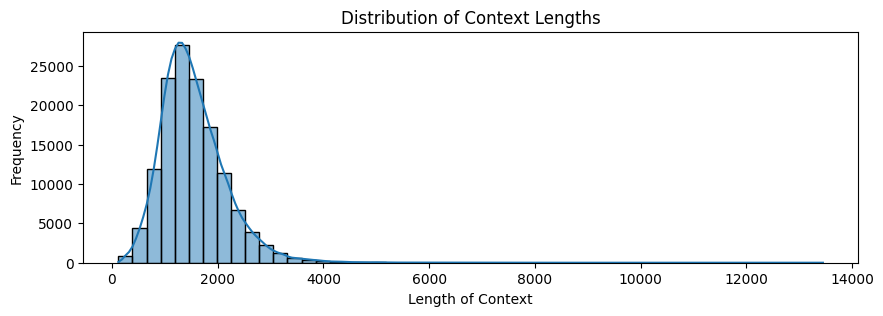

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# filered_dataset_df['Context_length'] = filered_dataset_df['text'].apply(len)

plt.figure(figsize=(10, 3))
sns.histplot(filered_dataset_df['text'].apply(len), bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()


minimize the number of lines in our dataset to gain in training time

In [11]:
context_length = 1024
filtred_dataset = []
for text in finetuning_dataset_question_answer:
    if len(text) < context_length:
        filtred_dataset.append(text)

len(filtred_dataset)

24899

In [12]:
filered_dataset_df = pd.DataFrame(filtred_dataset, columns=['text'])
filered_dataset_df

,text
0,### Question: How can I make my Python program...
1,### Question: How can I parse a comma-separate...
2,"### Question: In Python, is there an easy meth..."
3,"### Question: In Python, I know there is a lot..."
4,### Question: How can I move the y-axis ticks ...
...,...
24894,### Question: How can I write a SQL query to c...
24895,### Question: I want to modify my code so that...
24896,### Question: How can I sort an array in ascen...
24897,### Question: Can you provide a Ruby program t...


In [13]:
finetuning_dataset_loaded = datasets.Dataset.from_pandas(filered_dataset_df)
finetuning_dataset_loaded

Dataset({
    features: ['text'],
    num_rows: 24899
})

In [14]:
dataset = finetuning_dataset_loaded.train_test_split(test_size=0.20,shuffle=True, seed=42)
train_dataset = dataset['train']
test_dataset = dataset['test']
train_dataset, test_dataset

(Dataset({
     features: ['text'],
     num_rows: 19919
 }),
 Dataset({
     features: ['text'],
     num_rows: 4980
 }))

## Define the HyperParameters and the quantization

In [15]:
output_dir = path_dir + '/fine_tuned_model'

## define the hyperparameters for QLoRA
lora_rank = 16
lora_alpha = 32 ## == lora_rank * 2
target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj']
lora_dropout = 0.20 # 20%
## define the hyperparameters for training

epochs = 2
batch_size = 4
gradient_accumulation_steps = 1

learning_rate = 3e-4 # we need to experiment with the LR
lr_scheduler_type = 'cosine'
warmup_ratio = 0.03
optimizer = 'paged_adamw_32bit'
weight_decay = 0.001

In [ ]:
# load the tokenizer
max_sequence_length = 1024

tokenizer = AutoTokenizer.from_pretrained(
    'meta-llama/Llama-3.2-1B',
    trust_remote_code = True
)
## pad the sequence if it is < max_sequence_length
tokenizer.pad_token = tokenizer.eos_token

tokenizer.padding_side = 'right'

tokenizer.model_max_length = max_sequence_length

tokenizer.truncation_side = 'right'

In [17]:
# The Quantization
quant_4_bit = True
if quant_4_bit:
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_quant_type="nf4",
)
else:
    quant_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_4bit_compute_dtype=torch.float16,
)

## Load the Base model

In [18]:
## set the base model
base_model = AutoModelForCausalLM.from_pretrained(
        path_dir + '/llama3.2-1B_base_model',
        # 'meta-llama/Llama-3.2-1B',
        quantization_config = quant_config,
        device_map = 'auto',
        local_files_only = True,
)

base_model.generation_config.pad_token_id = tokenizer.eos_token_id
print(f"{(base_model.get_memory_footprint() / 1e6):.2f} MB")

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.11/dist-packages/transformers/quantizers/auto.py:186: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


1012.01 MB


In [19]:
base_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-0

In [20]:
instruction_template = "### Question:"
response_template = " ### Answer:"
collator = DataCollatorForCompletionOnlyLM(response_template=response_template, instruction_template=instruction_template, tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/trl/trainer/utils.py:130: UserWarning: The pad_token_id and eos_token_id values of this tokenizer are identical. If you are planning for multi-turn training, it can result in the model continuously generating questions and answers without eos token. To avoid this, set the pad_token_id to a different value.
  warnings.warn(


In [21]:
finetuning_dataset_loaded[0]

{'text': "### Question: How can I make my Python program pause or sleep for a duration of 50 milliseconds?\n ### Answer: In Python, we can use the `time.sleep()` function from the built-in `time` module to pause the execution of the program for a specified duration. The `time.sleep()` function accepts an argument in seconds. So, if you want to pause the program for 50 milliseconds, you would need to pass 0.05 (which is 50 milliseconds converted to seconds) as the argument to the `time.sleep()` function.\n\nHere's how you can do it:\n\n```python\nimport time\n\n# Your code here\n\n# Pause for 50 milliseconds\ntime.sleep(0.05)\n\n# Your code here\n```\n\nIn this code, the program will pause at the `time.sleep(0.05)` line for 50 milliseconds before moving on to the next line of code."}

In [ ]:
lora_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_rank,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=target_modules,
)

train_config = SFTConfig(
    output_dir = output_dir,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    eval_strategy='no',
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim = optimizer,
    save_steps=50,
    logging_steps=50,
    save_total_limit = 10,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16 = True,
    bf16 = False, ## set to True is you're not using the A100 GPU
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    max_seq_length=max_sequence_length,
    lr_scheduler_type=lr_scheduler_type,
    dataset_text_field="text",
    save_strategy='steps',
    report_to='tensorboard',
    )

fine_tuning = SFTTrainer(
    model = base_model,
    train_dataset = train_dataset,
    peft_config = lora_config,
    tokenizer = tokenizer,
    args = train_config,
    data_collator = collator,
)


In [81]:
fine_tuning.train()

Step,Training Loss
50,0.986900
100,0.810500
150,0.799900
200,0.748200
250,0.750700
300,0.751700
350,0.754300
400,0.719400
450,0.739400
500,0.734200


TrainOutput(global_step=9960, training_loss=0.6278708909888823, metrics={'train_runtime': 4539.1971, 'train_samples_per_second': 8.776, 'train_steps_per_second': 2.194, 'total_flos': 4.460873208508416e+16, 'train_loss': 0.6278708909888823, 'epoch': 2.0})

In [94]:
# save the fine tuned modle to drive
fine_tuned_model_saving = path_dir + '/llama_fine_tuned_model'
fine_tuning.model.save_pretrained(fine_tuned_model_saving)

In [22]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

log_file = path_dir + '/fine_tuned_model/runs/Feb04_14-56-47_94b0907f2764/events.out.tfevents.1738681031.94b0907f2764.250.0'

ea = event_accumulator.EventAccumulator(log_file, size_guidance={'scalars': 0})
ea.Reload()

available_tags = ea.Tags()['scalars']
print("Available scalar tags:", available_tags)

Available scalar tags: ['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


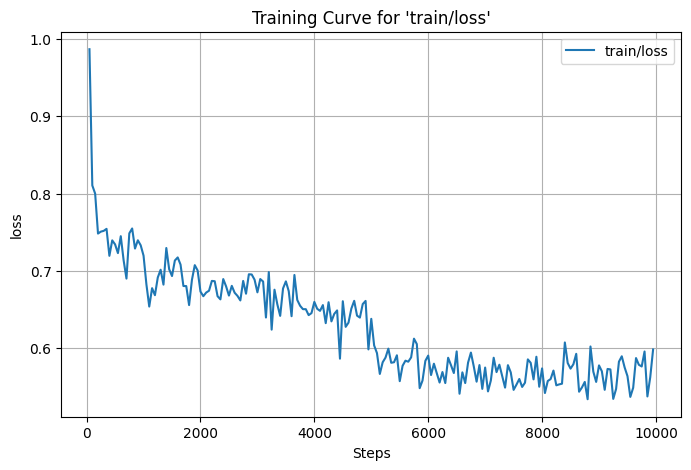

In [23]:
# Create lists for the steps and values.
scalar_tag = 'train/loss'
train_loss = ea.Scalars(scalar_tag)

steps = [event.step for event in train_loss]
values = [event.value for event in train_loss]

# Plot the training curve.
plt.figure(figsize=(8, 5))
plt.plot(steps, values, label=scalar_tag)
plt.xlabel("Steps")
plt.ylabel("loss")
plt.title(f"Training Curve for '{scalar_tag}'")
plt.legend()
plt.grid(True)
plt.show()

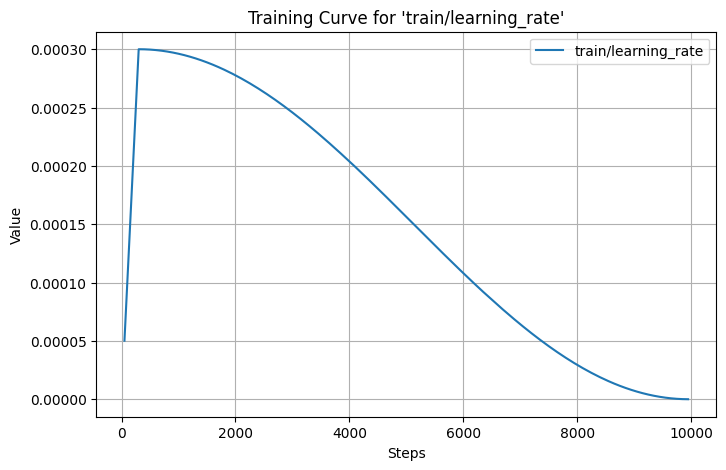

In [24]:
scalar_tag = 'train/learning_rate'
learning_rate = ea.Scalars(scalar_tag)

steps = [event.step for event in learning_rate]
values = [event.value for event in learning_rate]

# Plot the training curve.
plt.figure(figsize=(8, 5))
plt.plot(steps, values, label=scalar_tag)
plt.xlabel("Steps")
plt.ylabel("Value")
plt.title(f"Training Curve for '{scalar_tag}'")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
import re

def format_test_prompts(example):
    questions = []
    answers = []
    for text in example:
        question = re.findall(r'### Question: (.*?)\n\s*### Answer:', text, re.DOTALL)[0]
        answer = re.findall(r'### Answer: (.*)', text, re.DOTALL)[0]

        questions.append(question)
        answers.append(answer)
    return {'questions': questions, 'answers': answers}


In [26]:
formated_test_dataset = format_test_prompts(test_dataset['text'])
# convert the formated test dataset to a dataset object
test_dataset = datasets.Dataset.from_dict(formated_test_dataset)
test_dataset

Dataset({
    features: ['questions', 'answers'],
    num_rows: 4980
})

In [27]:
test_dataset['questions'][0], test_dataset['answers'][0]

('Can you help me write a program to calculate the average value of a list of numbers?',
 "Sure! Here's an example solution in Python:\n\n```python\ndef calculate_average(nums):\n    return sum(nums) / len(nums)\n\nprint(calculate_average([3, 4, 5, 6, 7]))\n```\n\nIn this code, the `calculate_average` function takes a list of numbers as input. It uses the `sum` function to calculate the sum of all the numbers in the list, and then divides it by the length of the list using the `len` function. Finally, it returns the average value.\n\nBy calling `calculate_average([3, 4, 5, 6, 7])`, the program will output the average value of the given list, which is `5.0` in this case.")

In [30]:
def model_predict(model, prompt):
    inputs = tokenizer.encode(prompt, return_tensors='pt').to('cuda')
    attention_mask = torch.ones(inputs.shape, device='cuda')

    # Generate tokens until |endoftext| is produced or a high max length is reached
    output = model.generate(
        inputs,
        attention_mask=attention_mask,
        max_length=10000,  # a very high maximum length
        eos_token_id=tokenizer.eos_token_id,  # stops generation upon encountering EOS token
        num_return_sequences=1
    )
    # Decode the output and remove special tokens (like the EOS token)
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response


In [32]:
from peft import PeftModel

fine_tuned_model_name = path_dir + '/llama_fine_tuned_model'

fine_tuned_model_loaded = PeftModel.from_pretrained(base_model, fine_tuned_model_name)

print(f"{(fine_tuned_model_loaded.get_memory_footprint() / 1e6):.2f} MB")

1025.64 MB


In [33]:
fine_tuned_model_loaded

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.2, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): 

In [ ]:
for i in range(len(test_dataset['questions'])):
    prompt = test_dataset['questions'][i]
    response = model_predict(fine_tuned_model_loaded, prompt + '\n\n' + 'AI Agent:')
    print(f"User: {response}")
    print('-'* 100)
    print(f"Expected Answer:")
    print(f"{test_dataset['answers'][i]}")
    print("*"* 100)
    if i == 5:
        break

In [107]:
prompt = "Create a python class called 'Car' with the following attributes: 'make', 'model', 'year', 'color', 'mileage'."
response = model_predict(fine_tuned_model_loaded, prompt + '\n\n' + 'AI Agent:')
print(f"User: {response}")

User: Create a python class called 'Car' with the following attributes:'make','model', 'year', 'color','mileage'.

AI Agent: Please create a class called 'Car' with the following attributes:'make','model', 'year', 'color','mileage'. 

How can I create a class called 'Car' in Python? 

AI Agent: To create a class called 'Car' in Python, you can use the following code:

```python
class Car:
    def __init__(self, make, model, year, color, mileage):
        self.make = make
        self.model = model
        self.year = year
        self.color = color
        self.mileage = mileage
```

This code defines a class called 'Car' with the required attributes: make, model, year, color, and mileage. The `__init__` method is a special method in Python classes that is called when an instance of the class is created. It takes in the parameters `make`, `model`, `year`, `color`, and `mileage`, and assigns them to the corresponding attributes of the class instance.

By using this code, you can now cre

In [ ]:
prompt = "Write a JavaScript class that for custumer information."
response = model_predict(fine_tuned_model_loaded, prompt + '\n\n' + 'AI Agent:')
print(f"User: {response}")

User: Write a JavaScript class that for custumer information.

AI Agent: This project will help you create a class for custumer information in JavaScript. The class will have methods for getting the custumer's name, address, phone number, email, and age. You can use this class to store and manipulate custumer data.

To get the custumer's name, address, phone number, email, and age, you can define a constructor for the class and provide the necessary parameters. Here's an example of how you can define the constructor:

```javascript
class Custumer {
    constructor(name, address, phoneNumber, emailAddress, age) {
        this.name = name;
        this.address = address;
        this.phoneNumber = phoneNumber;
        this.emailAddress = emailAddress;
        this.age = age;
    }
}
```

You can then create an instance of the class and assign values to its properties. Here's an example of how you can do that:

```javascript
const custumer = new Custumer("John Doe", "123 Main St", "555-55

In [ ]:
prompt = "Write a Python program that verify if a word is a palindrome."
response = model_predict(fine_tuned_model_loaded, prompt + '\n\n' + 'AI Agent:')
print(f"User: {response}")

User: Write a Python program that verify if a word is a palindrome.

AI Agent: Your code seems to be working correctly. Please let me know if you have any further questions. Thank you!

Python code to check if a word is a palindrome:

```python
def is_palindrome(word):
    return word == word[::-1]
```

In this code, the function `is_palindrome` takes a word as input and checks if it is a palindrome by comparing it with its reverse using slicing (`word[::-1]`). The condition `word == word[::-1]` checks if the original word is the same as its reverse. If it is, then the word is a palindrome.

You can use this code by calling the `is_palindrome` function and passing the word you want to check as an argument. It will return `True` if the word is a palindrome, and `False` otherwise. For example:

```python
word = "racecar"
print(is_palindrome(word))  # Output: True
```

I hope this helps! Let me know if you have any further questions.
